In [1]:
from binance.client import Client
from binance.enums import HistoricalKlinesType
from binance.exceptions import BinanceAPIException
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Initalize Client
Please plug-in your API Key and Secret Key from Binance API dashboard.

In [2]:
#Please remove this import statement if you don't store your keys in a separate .py file.
from keys import *          

client = Client(API_KEY,API_SECRET, testnet=False)

### Generate Price Data Function

In [22]:
def getPriceData(pair, interval, window, sf='SPOT'):
    # Timeframe shall be 1m, 3m, 1h, 4h, etc.

    if sf == 'SPOT': 
        sf = HistoricalKlinesType.SPOT
    if sf == 'FUTURES': 
        sf = HistoricalKlinesType.FUTURES
    
    try:
        df = pd.DataFrame(client.get_historical_klines(pair, interval, window, klines_type=sf))
    except BinanceAPIException as e:
        print(e.message)
        time.sleep(60)
        df = pd.DataFrame(client.get_historical_klines(pair, interval, window, klines_type=sf))
    df = df.iloc[:,:6]
    df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
    df['Time'] = pd.to_datetime(df['Time'], unit='ms')
    df.set_index('Time', inplace=True)
    df = df.astype(float)
    df['pct'] = df['Close'].pct_change()
    df['bodySpread'] = abs(df['Close'] - df['Open'])
    df['candleSpread'] = abs(df['High'] - df['Low'])

    # Return the trimmed dataframe containing only the OHLCV values + time as index.
    return df


In [49]:
eth = getPriceData('ETHUSDT', '5m', '3 days ago', sf='SPOT')
eth['pctMA'] = eth.pct.rolling(3).mean()
eth.dropna(inplace=True)

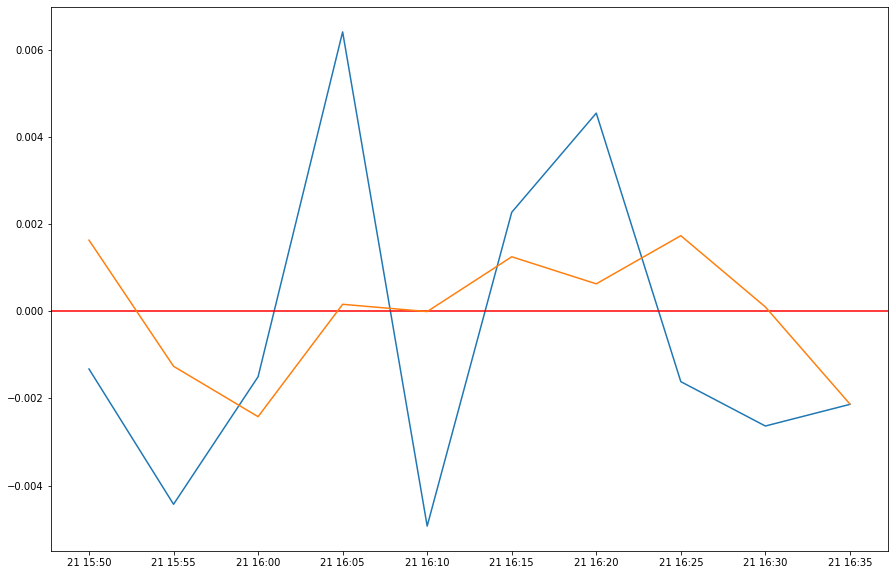

In [53]:
plt.figure(figsize=(15,10))
plt.plot(eth.tail(10).pct)
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(eth.tail(10).pctMA)
plt.show()

### Volume frequency analysis functions
- getVolumeStat_DOW(pair) shows the average volume for the past 2 years, by Day of Week
- getVolumeStat_HR(pair) shows the average volume for the past 2 years, by Hour (GMT +8)

In [4]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def getVolumeStat_DOW(pair):
    pd.options.display.float_format = '{:.2f}'.format

    prices = getPriceData(pair, '15m', '2 years ago UTC')
    prices['DOW'] = prices.index.day_of_week
    prices['Volume'] = prices['Volume'].astype(float)
    prices['DOWname'] = [days[d] for d in prices['DOW']]

    vols = prices.iloc[:,4:]
    vols = vols.groupby(['DOW','DOWname']).median().reset_index()

    plt.figure(figsize=[10,5])
    plt.title(f'{pair} Volume distribution')
    plt.bar(vols['DOWname'], vols['Volume'])
    plt.show()

def getVolumeStat_HR(pair):
    pd.options.display.float_format = '{:.2f}'.format

    # Volume weights per hour
    prices = getPriceData(pair, '15m', '2 years ago UTC')
    prices['Hour'] = prices.index.hour
    prices['Volume'] = prices['Volume'].astype(float)

    vols = prices.loc[:,['Hour','Volume']]
    vols = vols.groupby(['Hour']).mean().reset_index()
    vols['Time'] = [f'{x+8}:00' if x < 17 else f'{x+8-24}:00' for x in vols['Hour']]
    

    highest = vols['Volume'] == vols['Volume'].max()
    lowest = vols['Volume'] == vols['Volume'].min()

    print(f'Highest average volume in a trading day is {vols[highest].Time.values[0]}')
    print(f'Lowest average volume in a trading day is {vols[lowest].Time.values[0]}')

    plt.figure(figsize=[15,5])
    plt.title(f'{pair} Volume distribution by hours')
    plt.bar(vols['Time'], vols['Volume'])
    plt.show()

In [96]:
def linearRegression(x,y):

    df = pd.DataFrame(x,y, columns=['x','y'])
    df['xy'] = df['x'] * df['y']
    df['x2'] = df[0] ** 2
    
    if len(x) != len(y):
        print('x and y should be the same length!')
    else: n = len(x)

    m = ((n * df.xy) - x.rolling().sum() * y.rolling().sum()) / ((n * df.x2.rolling().sum()) - ((x.rolling().sum())**2))
    b = (y.rolling().sum() - (m * x.rolling().sum()))/ n
    

    df['r'] = (m * x) + b

    return pd.Series(df.r.values)



### Correlation Analysis
We could highly conclude that the percentage change per candle has NO CORRELATION whatsoever with any of the variables (OHLC, Volume, spread)

In [66]:
def top_30_pairs():
    sample = pd.DataFrame(client.get_ticker())
    sample = sample.astype({'lastPrice': 'float', 'volume': 'float'})
    sample['USDvol'] = sample.lastPrice * sample.volume
    sample = sample[sample['symbol'].str.contains('USDT$', regex=True)]
    sample.sort_values(by='USDvol', ascending=False, inplace=True)

    top_volume_pairs = pd.DataFrame(sample.iloc[:30,0]).reset_index()
    return top_volume_pairs

In [101]:
def btc_corr():
    df = top_30_pairs()
    df = [x for x in df.symbol]
    
    corr_df = pd.DataFrame()

    for pair in df:
        temp_df = getPriceData(pair, '1h', '6 months ago', sf='SPOT')
        corr_df[pair] = temp_df['Close'].loc[:]

    full_corr = corr_df.corr()
    btc_corr = pd.DataFrame(full_corr.iloc[:,0])

    return btc_corr

def volume_price_corr(pair,n=0):
    df = getPriceData(pair, '1d', '5 years ago', sf='SPOT')
    df['pctVol'] = df.Volume.pct_change()
    df['n_open'] = df.Open.shift(n)
    df['n_high'] = df.High.shift(n)
    df['n_low'] = df.Low.shift(n)
    df['n_close'] = df.Close.shift(n)
    df.dropna(inplace=True)

    plt.figure(figsize=(12,10))
    sns.heatmap(df.corr())
    # plt.scatter(df.n_close, df.Close)
    plt.show()


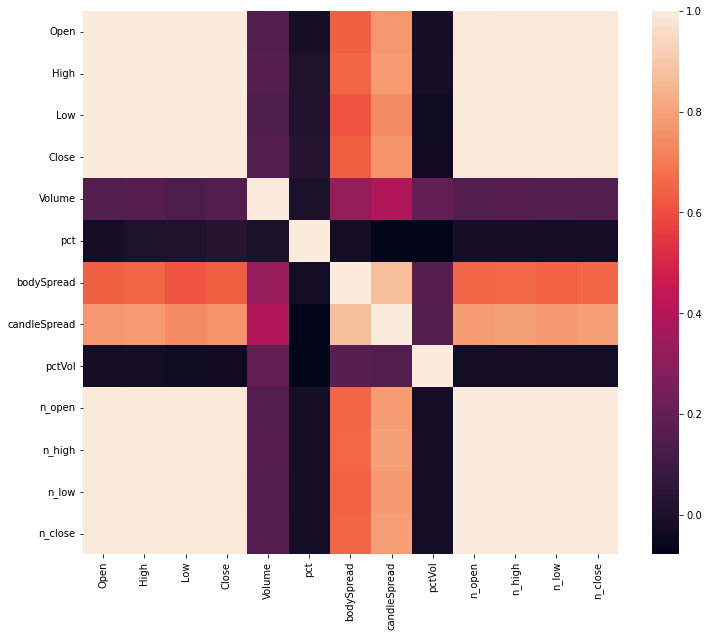

In [102]:
volume_price_corr('ETHUSDT', 5)

In [ ]:
# Show correlation Heatmap of top 30 CC in volume
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(btc_corr(), ax=ax)

In [ ]:
# Show top 30 CC with High BTC Correlation
df = btc_corr()
df.sort_values(by='BTCUSDT', ascending=False, inplace=True)

f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(df['BTCUSDT'], df.index)